In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP Label'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(137, 298)
(137, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[8])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['ATP Label'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[1])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(34, 298)
(34, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(200, 298)
(200, 298)
(200, 298)
(202, 298)
(202, 298)
(202, 298)
(202, 298)
(202, 298)


In [5]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(200, 298)
(200, 298)
(200, 298)
(202, 298)
(202, 298)
(202, 298)
(202, 298)
(202, 298)
----------
(234, 298)
(234, 298)
(234, 298)
(236, 298)
(236, 298)
(236, 298)
(236, 298)
(236, 298)
Label shapes
(200, 1)
(200, 1)
(200, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
(202, 1)
----------
(234, 1)
(234, 1)
(234, 1)
(236, 1)
(236, 1)
(236, 1)
(236, 1)
(236, 1)


In [6]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [7]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.610920 using {'batch_size': 30, 'dropout': 0.2, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 25}
D_in, H1, H2, D_out = 298, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 18
test_size1 = 17

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [8]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [9]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_hyp.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_hyp.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_hyp.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_hyp.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_hyp.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_hyp.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_hyp.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_hyp.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.37864 | Acc: 54.000
Validation Accuracy |  16.666666666666664  PPV |  [0.         0.16666667]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 002: | Loss: 2.33559 | Acc: 48.750
Validation Accuracy |  27.77777777777778  PPV |  [1.     0.1875]  Recall |  [0.13333333 1.        ]
Training Epoch 003: | Loss: 1.60558 | Acc: 54.125
Validation Accuracy |  38.88888888888889  PPV |  [0.83333333 0.16666667]  Recall |  [0.33333333 0.66666667]
Training Epoch 004: | Loss: 1.44033 | Acc: 52.625
Validation Accuracy |  33.33333333333333  PPV |  [1.  0.2]  Recall |  [0.2 1. ]
Training Epoch 005: | Loss: 1.33968 | Acc: 50.375
Validation Accuracy |  22.22222222222222  PPV |  [1.         0.17647059]  Recall |  [0.06666667 1.        ]
Training Epoch 006: | Loss: 1.24240 | Acc: 52.500
Validation Accuracy |  27.77777777777778  PPV |  [1.     0.1875]  Recall |  [0.13333333 1.        ]
Training Epoch 007: | Loss: 1.22411 | Acc: 52.250
Validation Accuracy |  27.77777777777778  PPV |  [1.     0.1875]  Recall |  [0.13333333 1.        ]
Training Epoch 008: | Loss: 1.14267 | Acc: 51.750
Validation Accuracy |  27.77777777777778  PPV |  [1.  

Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 057: | Loss: 0.20487 | Acc: 96.250
Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 058: | Loss: 0.18138 | Acc: 96.625
Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 059: | Loss: 0.19347 | Acc: 96.125
Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 060: | Loss: 0.17086 | Acc: 97.750
Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 061: | Loss: 0.20241 | Acc: 97.125
Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]
Training Epoch 062: | Loss: 0.16062 | Acc: 97.000
Validation Accuracy |  66.66666666666666  PPV |  [0.

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.97279 | Acc: 61.625
Validation Accuracy |  5.88235294117647  PPV |  [0.     0.0625]  Recall |  [0.  0.5]
Training Epoch 002: | Loss: 2.04601 | Acc: 50.250
Validation Accuracy |  5.88235294117647  PPV |  [0.     0.0625]  Recall |  [0.  0.5]
Training Epoch 003: | Loss: 1.46933 | Acc: 55.875
Validation Accuracy |  23.52941176470588  PPV |  [0.75       0.07692308]  Recall |  [0.2 0.5]
Training Epoch 004: | Loss: 1.26234 | Acc: 61.000
Validation Accuracy |  5.88235294117647  PPV |  [0.     0.0625]  Recall |  [0.  0.5]
Training Epoch 005: | Loss: 1.20309 | Acc: 51.875
Validation Accuracy |  5.88235294117647  PPV |  [0.     0.0625]  Recall |  [0.  0.5]
Training Epoch 006: | Loss: 1.13906 | Acc: 55.500
Validation Accuracy |  23.52941176470588  PPV |  [0.66666667 0.        ]  Recall |  [0.26666667 0.        ]
Training Epoch 007: | Loss: 1.09969 | Acc: 62.500
Validation Accuracy |  5.88235294117647  PPV |  [0.33333333 0.        ]  Recall |  [0.06666667 0.        ]
T

Training Epoch 056: | Loss: 0.11672 | Acc: 99.500
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 057: | Loss: 0.11019 | Acc: 99.250
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 058: | Loss: 0.11752 | Acc: 98.750
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 059: | Loss: 0.07764 | Acc: 100.000
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 060: | Loss: 0.09043 | Acc: 99.125
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 061: | Loss: 0.07701 | Acc: 100.000
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 062: | Loss: 0.06707 | Acc: 100.000
Validation Ac

In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.20767 | Acc: 58.750
Validation Accuracy |  23.52941176470588  PPV |  [1.         0.13333333]  Recall |  [0.13333333 1.        ]
Training Epoch 002: | Loss: 2.11537 | Acc: 46.000
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 003: | Loss: 1.49336 | Acc: 49.750
Validation Accuracy |  58.82352941176471  PPV |  [1.         0.22222222]  Recall |  [0.53333333 1.        ]
Training Epoch 004: | Loss: 1.33392 | Acc: 53.500
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.16666667]  Recall |  [0.33333333 1.        ]
Training Epoch 005: | Loss: 1.31286 | Acc: 51.750
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 006: | Loss: 1.20391 | Acc: 51.500
Validation Accuracy |  29.411764705882355  PPV |  [1.         0.14285714]  Recall |  [0.2 1. ]
Training Epoch 007: | Loss: 1.21002 | Acc: 51.125
Validation Accuracy |  41.17647058823529 

Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 056: | Loss: 0.13310 | Acc: 99.250
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 057: | Loss: 0.11499 | Acc: 98.375
Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 058: | Loss: 0.13404 | Acc: 97.500
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 059: | Loss: 0.13006 | Acc: 97.500
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 060: | Loss: 0.11716 | Acc: 98.500
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 061: | Loss: 0.10679 | Acc: 97.750
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 062: 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 082: | Loss: 0.06886 | Acc: 98.625
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 083: | Loss: 0.07119 | Acc: 99.625
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 084: | Loss: 0.05597 | Acc: 99.625
Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 085: | Loss: 0.05938 | Acc: 99.625
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 086: | Loss: 0.07537 | Acc: 98.875
Validation Accuracy |  64.70588235294117  PPV |  [0.84615385 0.        ]  Recall |  [0.73333333 0.        ]
Training Epoch 087: | Loss: 0.08152 | Acc: 98.875
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training E

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.23529411764706  PPV |  [0.88235294 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.06155 | Acc: 99.500
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]
Training Epoch 098: | Loss: 0.05804 | Acc: 98.375
Validation Accuracy |  82.35294117647058  PPV |  [0.875 0.   ]  Recall |  [0.93333333 0.        ]
Training Epoch 099: | Loss: 0.05790 | Acc: 100.000
Validation Accuracy |  76.47058823529412  PPV |  [0.86666667 0.        ]  Recall |  [0.86666667 0.        ]
Training Epoch 100: | Loss: 0.07560 | Acc: 98.750
Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]


In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 4.13003 | Acc: 50.125
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 002: | Loss: 1.79267 | Acc: 50.625
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.42043 | Acc: 57.625
Validation Accuracy |  17.647058823529413  PPV |  [0.5        0.13333333]  Recall |  [0.07142857 0.66666667]
Training Epoch 004: | Loss: 1.34241 | Acc: 55.750
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.28171 | Acc: 53.875
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.21482 | Acc: 57.250
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.16938 | Acc: 57.000
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.09973 | Acc: 58.000
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.05030 | Acc: 62.125
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 0.95267 | Acc: 67.875
Validation Accuracy |  11.76470588235294  PPV |  [0.    0.125]  Recall |  [0.         0.66666667]
Training Epoch 011: | Loss: 0.91295 | Acc: 74.500
Validation Accuracy |  11.76470588235294  PPV |  [0.33333333 0.07142857]  Recall |  [0.07142857 0.33333333]
Training Epoch 012: | Loss: 0.89805 | Acc: 70.875
Validation Accuracy |  11.76470588235294  PPV |  [0.33333333 0.07142857]  Recall |  [0.07142857 0.33333333]
Training Epoch 013: | Loss: 0.85588 | Acc: 80.125
Validation Accuracy |  23.52941176470588  PPV |  [0.6        0.08333333]  Recall |  [0.21428571 0.33333333]
Training Epoch 014: | Loss: 0.76586 | Acc: 73.875
Validation Accuracy |  29.411764705882355  PPV |  [0.66666667 0.09090909]  Recall |  [0.28571429 0.33333333]
Training Epoch 015: | Loss: 0.78663 | Acc: 78.125
Validation Accuracy |  41.17647058823529  PPV |  [0.75       0.11111111]  Recall |  [0.42857143 0.33333333]
Training Epoch 016: | Loss: 0.74855 | Acc: 83.875
Validation 

Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]
Training Epoch 063: | Loss: 0.12192 | Acc: 98.250
Validation Accuracy |  82.35294117647058  PPV |  [0.86666667 0.5       ]  Recall |  [0.92857143 0.33333333]
Training Epoch 064: | Loss: 0.09273 | Acc: 99.250
Validation Accuracy |  82.35294117647058  PPV |  [0.86666667 0.5       ]  Recall |  [0.92857143 0.33333333]
Training Epoch 065: | Loss: 0.10169 | Acc: 99.625
Validation Accuracy |  82.35294117647058  PPV |  [0.86666667 0.5       ]  Recall |  [0.92857143 0.33333333]
Training Epoch 066: | Loss: 0.09583 | Acc: 98.375
Validation Accuracy |  82.35294117647058  PPV |  [0.86666667 0.5       ]  Recall |  [0.92857143 0.33333333]
Training Epoch 067: | Loss: 0.11919 | Acc: 98.000
Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]
Training Epoch 068: | Loss: 0.09605 | Acc: 98.375
Validation Accuracy |  82.35294117647058  PPV |  [0.

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.67455 | Acc: 53.250
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 002: | Loss: 1.99405 | Acc: 48.625
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.53032 | Acc: 50.750
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.23076923]  Recall |  [0.28571429 1.        ]
Training Epoch 004: | Loss: 1.37747 | Acc: 52.500
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.31435 | Acc: 55.000
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 006: | Loss: 1.23787 | Acc: 51.750
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 007: | Loss: 1.23202 | Acc: 53.625
Validation Accuracy |  29.411764705882355 

Training Epoch 056: | Loss: 0.12965 | Acc: 98.375
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 057: | Loss: 0.15836 | Acc: 97.125
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 058: | Loss: 0.11362 | Acc: 98.000
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 059: | Loss: 0.12487 | Acc: 98.875
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 060: | Loss: 0.11540 | Acc: 98.000
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 061: | Loss: 0.10946 | Acc: 98.500
Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]
Training Epoch 062: | Loss: 0.11829 | Acc: 99.125
Va

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.70459 | Acc: 49.000
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 002: | Loss: 2.24430 | Acc: 48.250
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 003: | Loss: 1.59630 | Acc: 53.500
Validation Accuracy |  52.94117647058824  PPV |  [0.875      0.22222222]  Recall |  [0.5        0.66666667]
Training Epoch 004: | Loss: 1.31638 | Acc: 58.625
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 005: | Loss: 1.29566 | Acc: 51.875
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 006: | Loss: 1.20023 | Acc: 54.875
Validation Accuracy |  35.294117647058826  PPV |  [0.8        0.16666667]  Recall |  [0.28571429 0.66666667]
Training Epoch 007: | Loss: 1.24420 | Acc: 56.875
Validation Accuracy |  29.4117647058823

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 052: | Loss: 0.20274 | Acc: 95.750
Validation Accuracy |  70.58823529411765  PPV |  [0.8 0. ]  Recall |  [0.85714286 0.        ]
Training Epoch 053: | Loss: 0.16294 | Acc: 98.875
Validation Accuracy |  82.35294117647058  PPV |  [0.82352941 0.        ]  Recall |  [1. 0.]
Training Epoch 054: | Loss: 0.17317 | Acc: 97.625
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 055: | Loss: 0.16754 | Acc: 97.500
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 056: | Loss: 0.15261 | Acc: 97.875
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 057: | Loss: 0.14583 | Acc: 97.125
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 058: | Loss: 0.14133 | Acc: 97.500
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 059: | Loss: 0.11986 | Acc: 99.250
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 060: | Loss: 0.18088 | Acc: 96.625
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 061: | Loss: 0.13957 | Acc: 98.000
Va

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 063: | Loss: 0.14500 | Acc: 96.750
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 064: | Loss: 0.14760 | Acc: 97.125
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 065: | Loss: 0.17296 | Acc: 97.625
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 066: | Loss: 0.17247 | Acc: 98.375
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 067: | Loss: 0.10784 | Acc: 99.125
Validation Accuracy |  70.58823529411765  PPV |  [0.8 0. ]  Recall |  [0.85714286 0.        ]
Training Epoch 068: | Loss: 0.10242 | Acc: 98.750
Validation Accuracy |  76.47058823529412  PPV |  [0.8125 0.    ]  Recall |  [0.92857143 0.        ]
Training Epoch 069: | Loss: 0.12997 | Acc: 98.500
Validation Accuracy |  7

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  82.35294117647058  PPV |  [0.82352941 0.        ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.11429 | Acc: 97.875
Validation Accuracy |  58.82352941176471  PPV |  [0.76923077 0.        ]  Recall |  [0.71428571 0.        ]
Training Epoch 073: | Loss: 0.11902 | Acc: 98.000
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 074: | Loss: 0.11860 | Acc: 98.000
Validation Accuracy |  70.58823529411765  PPV |  [0.8 0. ]  Recall |  [0.85714286 0.        ]
Training Epoch 075: | Loss: 0.13579 | Acc: 98.000
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 076: | Loss: 0.11402 | Acc: 98.500
Validation Accuracy |  64.70588235294117  PPV |  [0.78571429 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 077: | Loss: 0.08073 | Acc: 98.750
Validation Accuracy |  70.58823529411765  PPV |  [0.8 0. ]  Recall |  [0.85714286 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  76.47058823529412  PPV |  [0.8125 0.    ]  Recall |  [0.92857143 0.        ]
Training Epoch 097: | Loss: 0.09136 | Acc: 99.125
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 098: | Loss: 0.11757 | Acc: 96.125
Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]
Training Epoch 099: | Loss: 0.09093 | Acc: 99.625
Validation Accuracy |  76.47058823529412  PPV |  [0.8125 0.    ]  Recall |  [0.92857143 0.        ]
Training Epoch 100: | Loss: 0.07211 | Acc: 97.750
Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]


In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.99391 | Acc: 57.750
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 002: | Loss: 1.93684 | Acc: 48.750
Validation Accuracy |  35.294117647058826  PPV |  [0.8        0.16666667]  Recall |  [0.28571429 0.66666667]
Training Epoch 003: | Loss: 1.49386 | Acc: 58.000
Validation Accuracy |  35.294117647058826  PPV |  [0.71428571 0.1       ]  Recall |  [0.35714286 0.33333333]
Training Epoch 004: | Loss: 1.36592 | Acc: 55.625
Validation Accuracy |  41.17647058823529  PPV |  [0.83333333 0.18181818]  Recall |  [0.35714286 0.66666667]
Training Epoch 005: | Loss: 1.20367 | Acc: 57.250
Validation Accuracy |  41.17647058823529  PPV |  [0.83333333 0.18181818]  Recall |  [0.35714286 0.66666667]
Training Epoch 006: | Loss: 1.19367 | Acc: 57.250
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.23076923]  Recall |  [0.28571429 1.        ]
Training Epoch 007: | Loss: 1.17625 | Acc: 56.125
Validation Ac

Training Epoch 055: | Loss: 0.15829 | Acc: 95.750
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 056: | Loss: 0.13109 | Acc: 98.750
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 057: | Loss: 0.13851 | Acc: 97.875
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 058: | Loss: 0.11352 | Acc: 98.375
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 059: | Loss: 0.12535 | Acc: 97.875
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 060: | Loss: 0.13601 | Acc: 97.125
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 061: | Loss: 0.11211 | Acc: 98.250
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  82.35294117647058  PPV |  [0.82352941 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.11162 | Acc: 96.000
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 089: | Loss: 0.08508 | Acc: 99.625
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 090: | Loss: 0.07246 | Acc: 98.875
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 091: | Loss: 0.06522 | Acc: 98.875
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 092: | Loss: 0.05380 | Acc: 99.250
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 093: | Loss: 0.06218 | Acc: 98.750
Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]
Training Epoch 094: 

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.71555 | Acc: 56.000
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 002: | Loss: 2.36751 | Acc: 46.250
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.74299 | Acc: 48.500
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.40030 | Acc: 58.125
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 005: | Loss: 1.35871 | Acc: 52.750
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 006: | Loss: 1.37063 | Acc: 47.750
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 007: | Loss: 1.34661 | Acc: 49.875
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 008: | Loss: 1.32439 | Acc: 49.000
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.27177 | Acc: 49.125
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 1.23018 | Acc: 48.500
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 011: | Loss: 1.20255 | Acc: 51.500
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 012: | Loss: 1.18250 | Acc: 52.625
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 013: | Loss: 1.16591 | Acc: 51.500
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 014: | Loss: 1.06939 | Acc: 60.875
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.23076923]  Recall |  [0.28571429 1.        ]
Training Epoch 015: | Loss: 1.04721 | Acc: 57.875
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.23076923]  Recall |  [0.28571429 1.        ]
Training Epoch 016: | Loss: 1.04935 | Acc: 65.500
Validation Accuracy |  52.9411

Training Epoch 066: | Loss: 0.11733 | Acc: 98.000
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 067: | Loss: 0.13576 | Acc: 97.125
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 068: | Loss: 0.13555 | Acc: 96.375
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 069: | Loss: 0.16341 | Acc: 98.250
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 070: | Loss: 0.15390 | Acc: 94.625
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 071: | Loss: 0.15199 | Acc: 98.375
Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]
Training Epoch 072: | Loss: 0.12385 | Acc: 97.375
Va

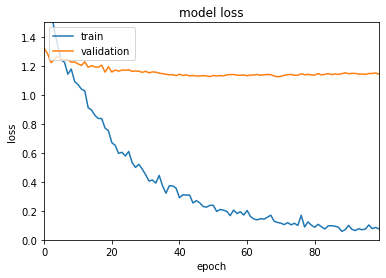

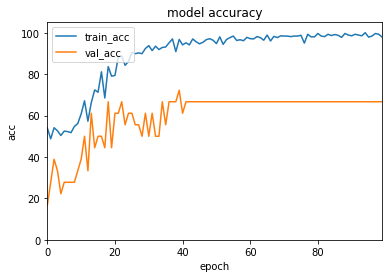

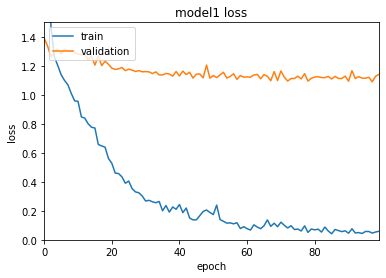

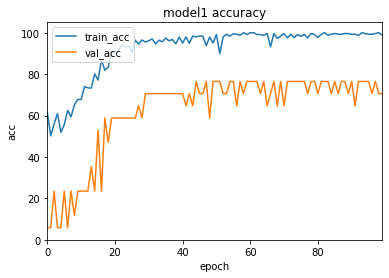

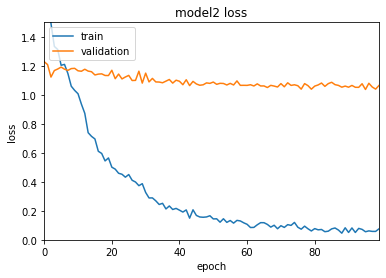

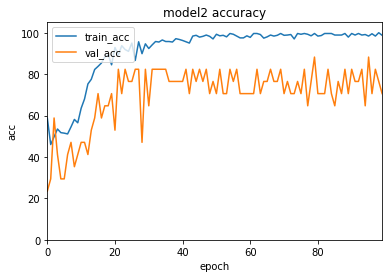

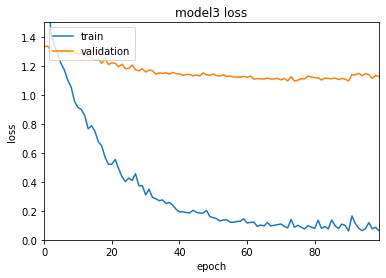

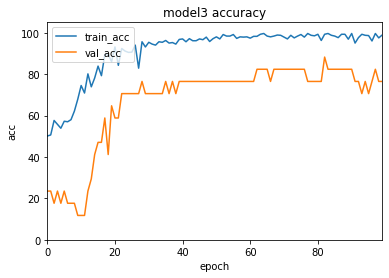

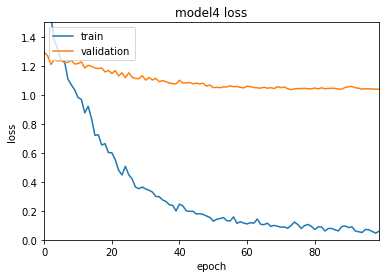

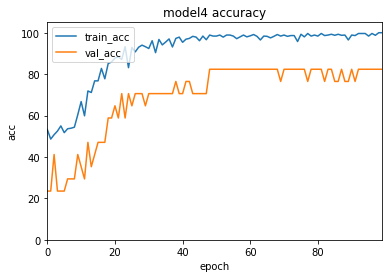

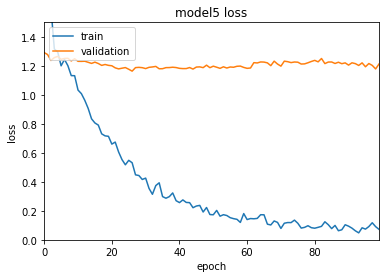

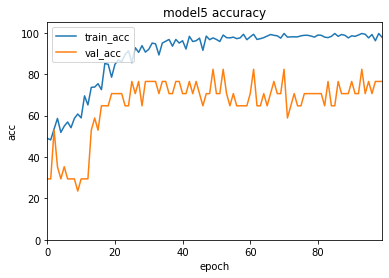

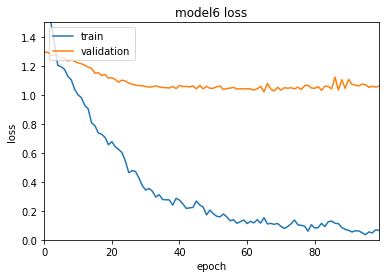

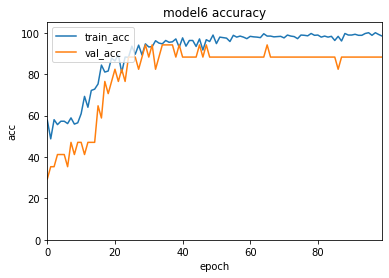

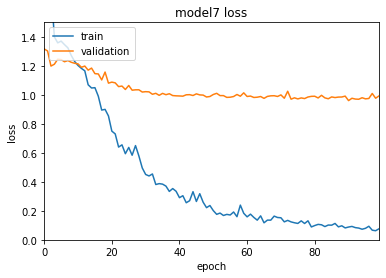

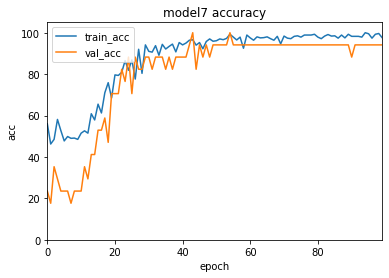

In [19]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  66.66666666666666  PPV |  [0.84615385 0.2       ]  Recall |  [0.73333333 0.33333333]


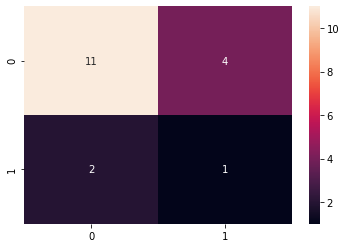

In [20]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]


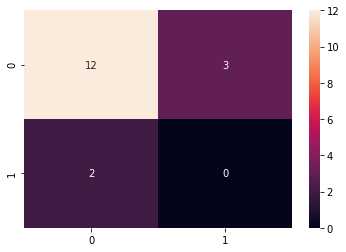

In [21]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  70.58823529411765  PPV |  [0.85714286 0.        ]  Recall |  [0.8 0. ]


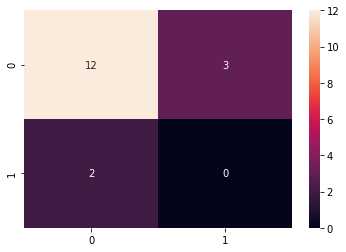

In [22]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]


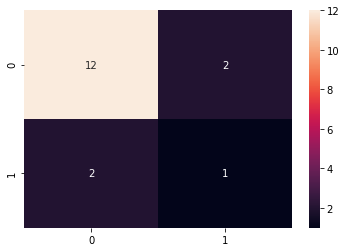

In [23]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  82.35294117647058  PPV |  [0.92307692 0.5       ]  Recall |  [0.85714286 0.66666667]


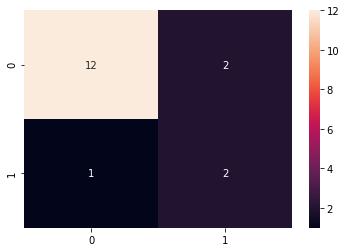

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  76.47058823529412  PPV |  [0.85714286 0.33333333]  Recall |  [0.85714286 0.33333333]


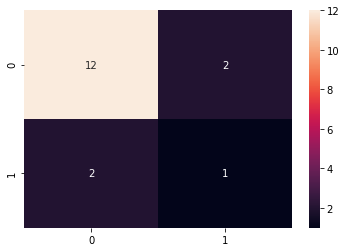

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  88.23529411764706  PPV |  [0.875 1.   ]  Recall |  [1.         0.33333333]


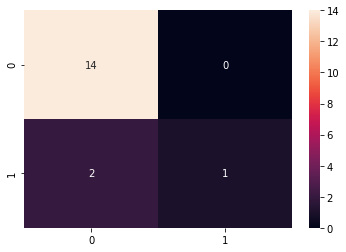

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  94.11764705882352  PPV |  [0.93333333 1.        ]  Recall |  [1.         0.66666667]


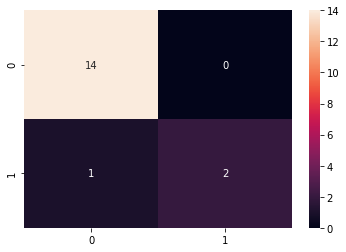

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [28]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[99 16]
 [14  8]]
Positive Predictive Value tp/(tp+fp):  0.3333333333333333
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.781021897810219
Recall Value tp/(tp+fn):  0.36363636363636365


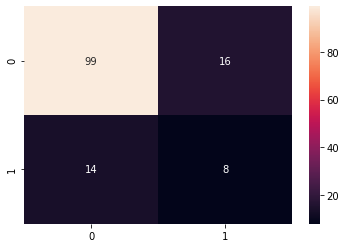

In [29]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 

In [30]:
#Line up Subjects by case number based on test_index in skf. This is done before smoting.
#Allows us to later check t-score to see if the models improve when using imputed data
#that we are able to classify the ones that have borderline t-scores (60 - 65 ish)
#Can create a histogram of the distribution based on correctly predicted vs incorrectly predicted

#Try the HYP Hyperparameters and pretraining on the ATP models
#Double check whether or not grid search included interpolated samples
#Could try and add twins into the testing/validation set

In [31]:
Twin_Validation = pd.ExcelFile("Scaled Twin CTSA1y with labels sex GA.xlsx") #298 Features, CT1y SA1y GA Sex
Twin_Labels = pd.ExcelFile("Twin Labels.xlsx") #Labels for twins

twin_data = Twin_Validation.parse(Twin_Validation.sheet_names[0])
twin_label_data = Twin_Labels.parse(Twin_Labels.sheet_names[0])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['ATP Label'], axis=1)
twin_labels = twin_label_data.loc[:, twin_label_data.columns]
twin_labels = twin_labels.drop(['ROI','ATP Middle', 'HYP Middle', 'HYP Label'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

(142, 298)
(142, 1)


In [32]:
type(twin_data_features) #Currently dataframe, needs to be numpy array
td_features = twin_data_features.to_numpy()
td_data = testData(torch.FloatTensor(td_features))

t_labels = twin_labels.to_numpy()

Validation Accuracy |  73.23943661971832  PPV |  [0.95238095 0.10810811]  Recall |  [0.7518797  0.44444444]
[[100  33]
 [  5   4]]


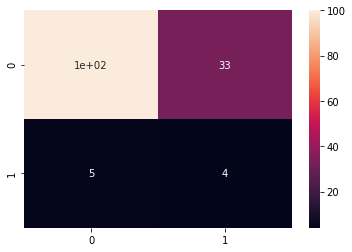

In [33]:
y_pred_list = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(t_labels, y_pred_list)
ppv = precision_score(t_labels, y_pred_list, average=None)
recall = recall_score(t_labels, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  68.30985915492957  PPV |  [0.94       0.07142857]  Recall |  [0.70676692 0.33333333]
[[94 39]
 [ 6  3]]


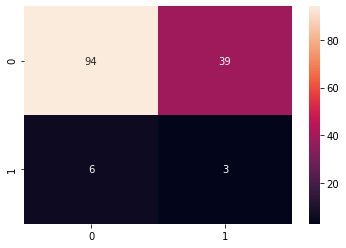

In [34]:
y_pred_list1 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list1.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list1 = [a.squeeze().tolist() for a in y_pred_list1]
accuracy = accuracy_score(t_labels, y_pred_list1)
ppv = precision_score(t_labels, y_pred_list1, average=None)
recall = recall_score(t_labels, y_pred_list1, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list1)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  74.64788732394366  PPV |  [0.95327103 0.11428571]  Recall |  [0.76691729 0.44444444]
[[102  31]
 [  5   4]]


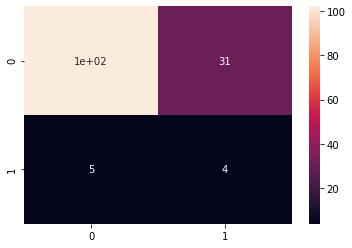

In [35]:
y_pred_list2 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list2.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list2 = [a.squeeze().tolist() for a in y_pred_list2]
accuracy = accuracy_score(t_labels, y_pred_list2)
ppv = precision_score(t_labels, y_pred_list2, average=None)
recall = recall_score(t_labels, y_pred_list2, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list2)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  72.53521126760563  PPV |  [0.95192308 0.10526316]  Recall |  [0.7443609  0.44444444]
[[99 34]
 [ 5  4]]


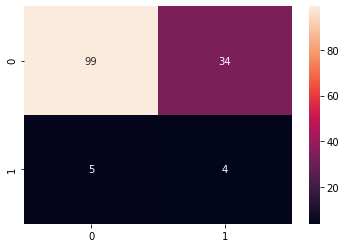

In [36]:
y_pred_list3 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list3.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list3 = [a.squeeze().tolist() for a in y_pred_list3]
accuracy = accuracy_score(t_labels, y_pred_list3)
ppv = precision_score(t_labels, y_pred_list3, average=None)
recall = recall_score(t_labels, y_pred_list3, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list3)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  71.83098591549296  PPV |  [0.94285714 0.08108108]  Recall |  [0.7443609  0.33333333]
[[99 34]
 [ 6  3]]


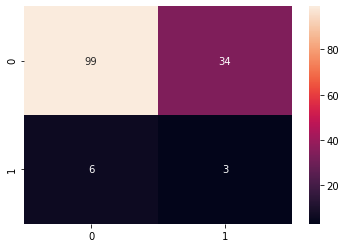

In [37]:
y_pred_list4 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list4.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list4 = [a.squeeze().tolist() for a in y_pred_list4]
accuracy = accuracy_score(t_labels, y_pred_list4)
ppv = precision_score(t_labels, y_pred_list4, average=None)
recall = recall_score(t_labels, y_pred_list4, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list4)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  72.53521126760563  PPV |  [0.95192308 0.10526316]  Recall |  [0.7443609  0.44444444]
[[99 34]
 [ 5  4]]


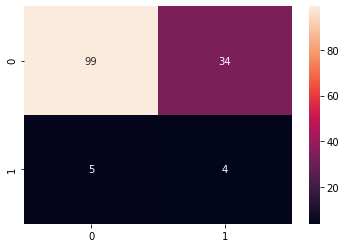

In [38]:
y_pred_list5 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list5.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list5 = [a.squeeze().tolist() for a in y_pred_list5]
accuracy = accuracy_score(t_labels, y_pred_list5)
ppv = precision_score(t_labels, y_pred_list5, average=None)
recall = recall_score(t_labels, y_pred_list5, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list5)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  78.16901408450704  PPV |  [0.94736842 0.10714286]  Recall |  [0.81203008 0.33333333]
[[108  25]
 [  6   3]]


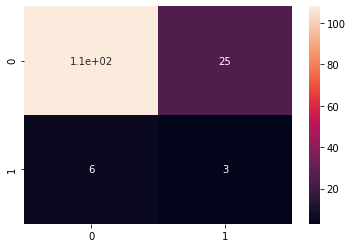

In [39]:
y_pred_list6 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list6.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list6 = [a.squeeze().tolist() for a in y_pred_list6]
accuracy = accuracy_score(t_labels, y_pred_list6)
ppv = precision_score(t_labels, y_pred_list6, average=None)
recall = recall_score(t_labels, y_pred_list6, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list6)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  78.16901408450704  PPV |  [0.94736842 0.10714286]  Recall |  [0.81203008 0.33333333]
[[108  25]
 [  6   3]]


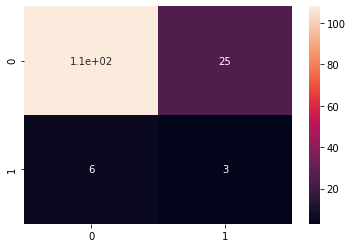

In [40]:
y_pred_list7 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list7.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list7 = [a.squeeze().tolist() for a in y_pred_list7]
accuracy = accuracy_score(t_labels, y_pred_list7)
ppv = precision_score(t_labels, y_pred_list7, average=None)
recall = recall_score(t_labels, y_pred_list7, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list7)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

In [41]:
final_twin_pred = []
for x in range(0,142):
    count = 0
    if(y_pred_list[x] == 1.0):
        count += 1
    if(y_pred_list1[x] == 1.0):
        count += 1
    if(y_pred_list2[x] == 1.0):
        count += 1
    if(y_pred_list3[x] == 1.0):
        count += 1
    if(y_pred_list4[x] == 1.0):
        count += 1
    if(y_pred_list5[x] == 1.0):
        count += 1
    if(y_pred_list6[x] == 1.0):
        count += 1
    if(y_pred_list7[x] == 1.0):
        count += 1
    if(count > 4):
        final_twin_pred.append(1.0)
    else:
        final_twin_pred.append(0.0)

print(final_twin_pred)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Validation Accuracy |  76.76056338028168  PPV |  [0.94642857 0.1       ]  Recall |  [0.79699248 0.33333333]
[[106  27]
 [  6   3]]


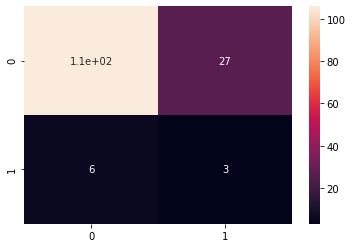

In [42]:
accuracy = accuracy_score(t_labels, final_twin_pred)
ppv = precision_score(t_labels, final_twin_pred, average=None)
recall = recall_score(t_labels, final_twin_pred, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, final_twin_pred)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)